# Trabajo Practico N° 2
El objetivo de este trabajo practico es integrar los conocimientos adquiridos en las unidades 4 y 5 en dos problemas reales asociados uno al comportamiento financiero de 1000 empresas y otro a un juego de cartas.

Importar librerías necesarias

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ptitprince as pt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn.tree import export_text, DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')


# Parte I: Regresión (Ítems 1 y 2)

## 1 - Análisis exploratorio de los datos

In [11]:
# Importa el archivo CSV en un DataFrame de Pandas
companies_df= pd.read_csv("Datasets/1000_Companies.csv")

### 1.1 - Descripción del dataset

**R&D Spend**
> Esta característica representa la cantidad de dinero que una startup gasta en actividades de investigación y desarrollo. Indica la inversión realizada en la creación de nuevos productos, la mejora de los existentes o el fortalecimiento de las capacidades tecnológicas en general.

**Administration**
> Esta característica representa la cantidad de dinero que una startup gasta en tareas administrativas y gastos generales. Incluye costos asociados con el espacio de oficina, servicios públicos, salarios del personal no relacionado con la producción y otros gastos operativos generales.

**Marketing Spend**
> Esta característica representa la cantidad de dinero que una startup invierte en actividades de marketing y promoción. Incluye gastos relacionados con campañas publicitarias, esfuerzos de marketing en línea, relaciones públicas y otras iniciativas destinadas a aumentar la visibilidad de la marca y atraer clientes.

**State**
> Esta característica captura el estado en el que opera cada startup. Se representa como un objeto, lo que sugiere que contiene información categórica o textual sobre la ubicación geográfica de la empresa. La información sobre el estado puede ser útil para analizar tendencias regionales o identificar posibles variaciones en los costos operativos y las ganancias en diferentes ubicaciones.

**Profit**
> Esta característica representa la rentabilidad de cada startup. Indica la ganancia o pérdida financiera generada por la empresa en un período específico. La ganancia se mide típicamente restando los ingresos obtenidos de los costos operativos totales incurridos, que incluyen el gasto en investigación y desarrollo, gastos administrativos, gastos de marketing y otros factores relevantes.

In [35]:
# Usar el método .info() para obtener información sobre el DataFrame
print("Información del DataFrame:")
companies_df.info()

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       1000 non-null   float64
 1   Administration  1000 non-null   float64
 2   MarketingSpend  1000 non-null   float64
 3   State           1000 non-null   object 
 4   Profit          1000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 39.2+ KB


> El DataFrame tiene un índice que es un rango que va desde 0 hasta 999, lo que significa que hay 1000 filas en el DataFrame, tiene un total de 5 columnas, no falta ningún dato. La mayoría de las columnas, al ser montos de dinero y en consecuencia números reales, están en formato float. Solo la columna que indica en qué estado opera cada startup está en formato object, es decir string para Pandas.

### 1.2 - Distribuciones de los datos
En esta sección se utilizaron raincloud plots para ilustrar la distribución de los datos.

Los raincloud plots o gráficos de lluvia combinan una representación de la distribución de datos (la 'nube') con datos brutos dispersos (la 'lluvia') y se complementan aún más añadiendo boxplots.

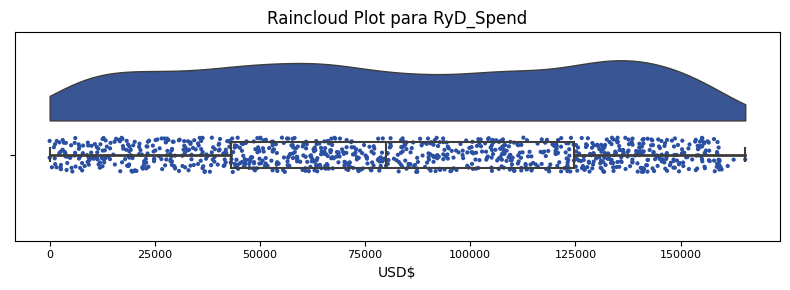

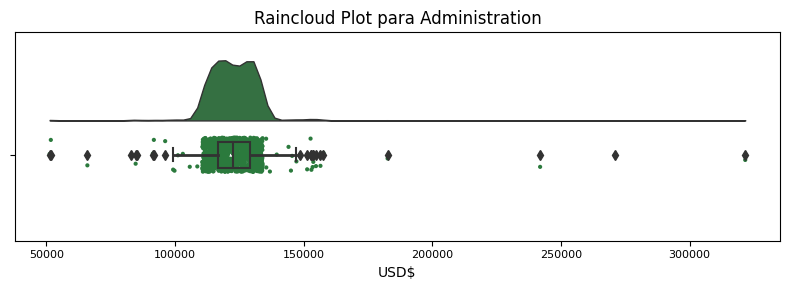

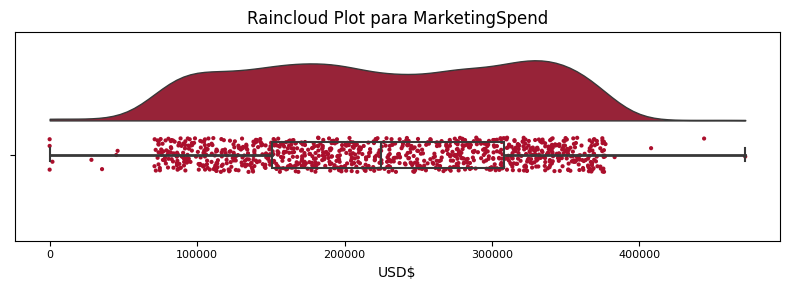

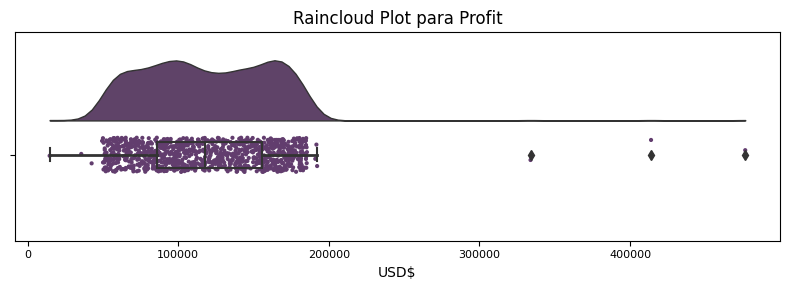

In [36]:
# Filtrar solo las columnas numéricas
numeric_columns = companies_df.select_dtypes(include='number')

# Paleta de colores
colors = ['#2a4fa3', '#2b7a3d', '#ab0f2c', '#623d6e']

# Iterar a través de las columnas numéricas y crear un raincloud plot para cada una en su propia figura
for i, column_name in enumerate(numeric_columns.columns):
    # Configurar una nueva figura para cada columna
    plt.figure(figsize=(8, 3))

    # Crear el raincloud plot para la columna actual
    ax = pt.RainCloud(data=numeric_columns[column_name], orient='h', palette=[colors[i]])

    # Personalizar etiquetas de ejes y título para cada figura
    plt.xlabel('USD$', fontsize=10)
    plt.title(f'Raincloud Plot para {column_name}', fontsize=12)

    # Eliminar los números del eje y
    ax.set_yticklabels([])

    # Reducir el tamaño de los números en los ejes
    ax.tick_params(axis='both', labelsize=8)

    # Ajustar el espacio en blanco entre el eje x y el gráfico
    plt.tight_layout()

    # Mostrar la figura actual
    plt.show()

> Los gráficos muestran que mientras que los montos invertidos en actividades de investigación y desarrollo y de marketing y promoción se encuentran con una distribución bastante uniforme sin una moda clara, los montos para tareas administrativas y gastos generales y ganancias, se encuentran sesgadas hacia la izquierda con unos escasos outliers hacia los valores muy altos.

### 1.3 - Eliminación de outliers

En esta sección, se procede a la identificación y eliminación de valores atípicos, mediante la selección de un factor de rango intercuartílico apropiado. El objetivo es preservar la integridad del conjunto de datos al no eliminar más del 5% de los registros, una proporción ampliamente reconocida como estándar en la industria.

In [37]:
# Definir función de para eliminar outliers
def remove_outliers_iqr(df, column_name, iqr_factor=1.5):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_factor * IQR
    upper_bound = Q3 + iqr_factor * IQR
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

In [38]:
# Lista de columnas numéricas en las que deseas eliminar outliers
numeric_columns = companies_df.select_dtypes(include='number')

# Crear copia del dataframe
filtered_df = companies_df.copy()

# Factor de multiplicación del rango intercuartil
iqr_factor = 1.5

# Itera a través de las columnas numéricas y elimina los outliers
for columna in numeric_columns:
    filtered_df = remove_outliers_iqr(filtered_df, columna, iqr_factor)

# Utiliza el método reset_index() para restablecer los índices
filtered_df = filtered_df.reset_index(drop=True)

In [39]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       978 non-null    float64
 1   Administration  978 non-null    float64
 2   MarketingSpend  978 non-null    float64
 3   State           978 non-null    object 
 4   Profit          978 non-null    float64
dtypes: float64(4), object(1)
memory usage: 38.3+ KB


In [40]:
print(f'Porcentaje de datos eliminados: {100*(1-len(filtered_df)/len(companies_df)):.1f}%')

Porcentaje de datos eliminados: 2.2%


Al eliminar los valores atípicos, se excluyó un 2.2% del conjunto de datos en su totalidad, lo cual se encuentra por debajo del umbral admisible universalmente del 5%.


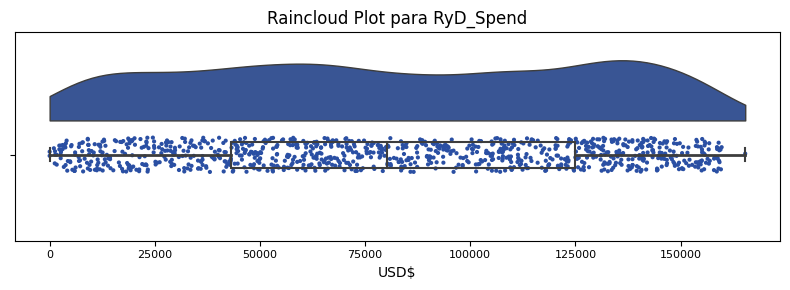

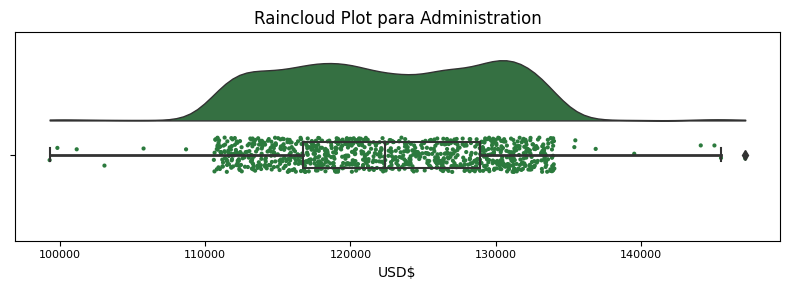

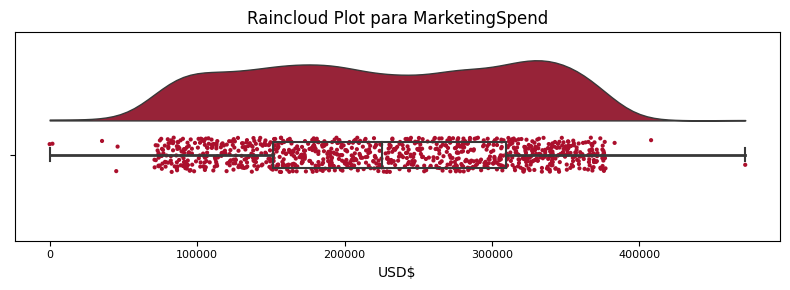

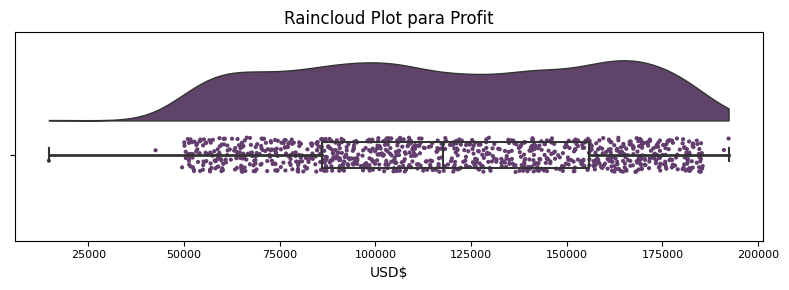

In [41]:
# Filtrar solo las columnas numéricas
numeric_columns =filtered_df.select_dtypes(include='number')

# Paleta de colores pastel
colors = ['#2a4fa3', '#2b7a3d', '#ab0f2c', '#623d6e']

# Iterar a través de las columnas numéricas y crear un raincloud plot para cada una en su propia figura
for i, column_name in enumerate(numeric_columns.columns):
    # Configurar una nueva figura para cada columna
    plt.figure(figsize=(8, 3))  # Reducir la altura de la figura

    # Crear el raincloud plot para la columna actual
    ax = pt.RainCloud(data=numeric_columns, y = column_name, orient='h', palette=[colors[i]])


    # Personalizar etiquetas de ejes y título para cada figura
    plt.xlabel('USD$', fontsize=10)
    plt.title(f'Raincloud Plot para {column_name}', fontsize=12)

    # Eliminar los números del eje y
    ax.set_yticklabels([])

    # Reducir el tamaño de los números en los ejes
    ax.tick_params(axis='both', labelsize=8)

    # Ajustar el espacio en blanco entre el eje x y el gráfico
    plt.tight_layout()

    # Mostrar la figura actual
    plt.show()

Ahora puede observarse cómo ahora todas las columnas están más uniformemente distribuídas.

### 1.4 - Correlación entre variables
En esta sección del informe, se realiza un análisis de la correlación entre las variables presentes en el conjunto de datos. Se emplean dos enfoques principales para visualizar esta relación:

**Pairplot de Seaborn**
> Se genera un conjunto de gráficos de dispersión que permite la exploración visual de la relación entre pares de variables. Este enfoque proporciona una mejor comprensión de cómo las variables interactúan entre sí y si existe una correlación lineal evidente.

**Heatmap de la Matriz de Correlación**
> Se crea un mapa de calor que representa la matriz de correlación de las variables. Este mapa visualiza de manera eficiente las fuerzas y direcciones de las relaciones entre las variables, destacando la intensidad de la correlación mediante una escala de colores.

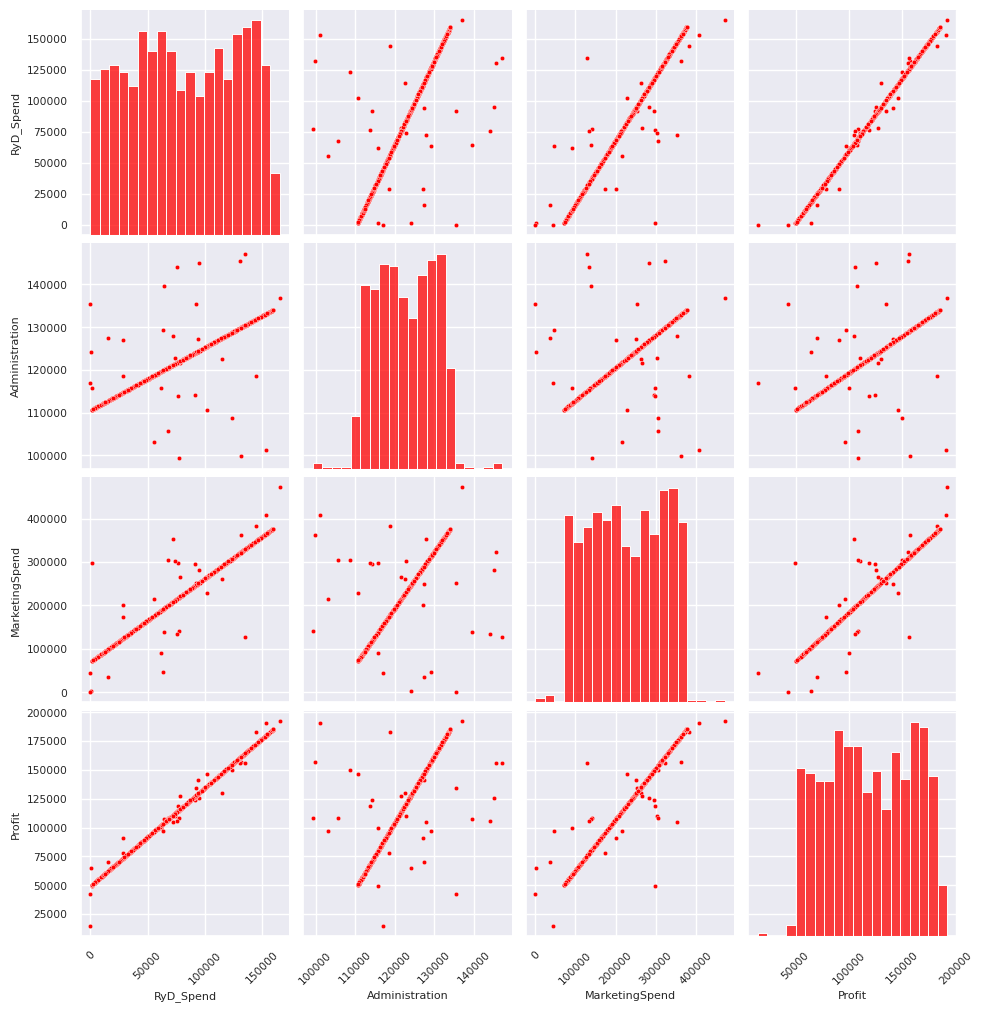

In [42]:
# Crea un pairplot de las variables numéricas con tamaños de fuente más pequeños
sns.set(font_scale=0.7)  # Ajusta el tamaño de fuente

# Crear un pairplot
pairplot = sns.pairplot(filtered_df.select_dtypes(include=['number']), plot_kws={'color': 'red', 's': 10}, diag_kws={'color': 'red', 'bins': 20})


# Personaliza el tamaño de fuente de las etiquetas de los ejes
for ax in pairplot.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=8)  # Tamaño de fuente para las etiquetas del eje x
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)  # Tamaño de fuente para las etiquetas del eje y

# Rota los números en el eje x 45 grados
for ax in pairplot.axes[-1]:
    ax.tick_params(axis='x', labelrotation=45)

# Muestra el gráfico
plt.show()


> La matriz de gráficos de dispersión para los pares de características revelan una correlación lineal casi perfecta, los puntos se alinean en líneas rectas perfectamente identificables.


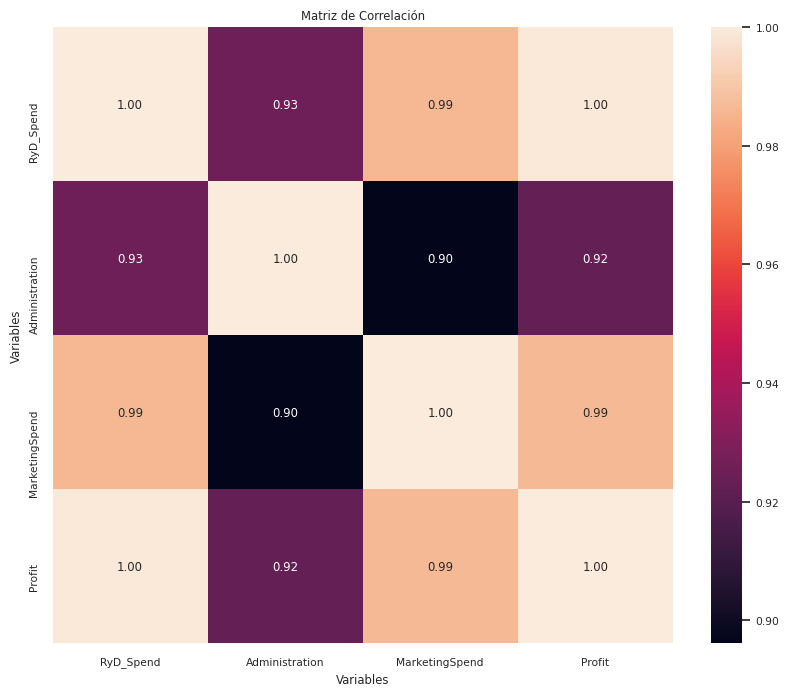

In [43]:
# Calcula la matriz de correlación
correlation_matrix = filtered_df.corr()

# Configura el tamaño de la figura
plt.figure(figsize=(10, 8))

# Crea el mapa de calor (heatmap) de la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='rocket', fmt=".2f")

# Personaliza las etiquetas de los ejes y el título
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.title("Matriz de Correlación")

# Muestra el gráfico
plt.show()


> Puede observarse en el mapa de calor de la matriz de correlación una alta correlación lineal entre las variables del dataset, no bajando de 0.9.

### 1.5 - Estandarización
Se ha elegido la técnica de escalamiento Min-Max. Esta elección se basa en varios factores clave que incluyen la falta de una distribución normal en los datos, lo cual descarta la aplicación de la transformación Z-Score. Además, la eliminación de valores atípicos previamente realizada descarta el uso de un enfoque robusto, y la inexistencia de una relación logarítmica en los datos hace inapropiado el empleo de la técnica homónima.

In [44]:
# Hacer una copia del DataFrame original
standarized_df = filtered_df.copy()

# Seleccionar las columnas numéricas para estandarizar (excluyendo "Profit")
numeric_columns = [col for col in filtered_df.select_dtypes(include='number').columns if col != "Profit"]

# Crear un MinMaxScaler
scaler = MinMaxScaler()

# Estandarizar las columnas numéricas seleccionadas
standarized_df[numeric_columns] = scaler.fit_transform(filtered_df[numeric_columns])

standarized_df

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,1.000000,0.785025,1.000000,New York,192261.83000
1,0.927985,0.038905,0.864664,Florida,191050.39000
2,0.873136,0.404664,0.812235,New York,182901.99000
3,0.797566,0.011131,0.769126,New York,156991.12000
4,0.814128,1.000000,0.270710,California,156122.51000
...,...,...,...,...,...
973,0.635788,0.557236,0.575733,Florida,138841.98810
974,0.283025,0.377463,0.337179,California,89012.02672
975,0.587901,0.532833,0.543350,New York,132077.70900
976,0.327398,0.400076,0.367186,California,95279.96251


### 1.6 - Codificación de variables categóricas

En esta sección se aborda el proceso de codificación de variables categóricas, un paso esencial en la preparación de los datos para su análisis y modelado. El método seleccionado para llevar a cabo esta tarea es el "one-hot encoding". Este enfoque consiste en transformar las variables categóricas en variables binarias (0 y 1) independientes, lo que facilita la interpretación por parte de los modelos de árboles de decisión para regresión.

In [45]:
# Crear una instancia de OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')

# Realizar One-Hot Encoding en la columna 'State'
encoded_states = encoder.fit_transform(standarized_df['State'].values.reshape(-1, 1))

# Crear un DataFrame con las columnas codificadas
encoded_df = pd.DataFrame(encoded_states, columns=encoder.get_feature_names_out(['State']))

# Agregar las columnas de 'standarized_df' que no sean 'State' al DataFrame codificado
encoded_df = pd.concat([standarized_df.drop('State', axis=1), encoded_df], axis=1)

# Imprimir el dataframe codificado
encoded_df

,RyD_Spend,Administration,MarketingSpend,Profit,State_Florida,State_New York
0,1.000000,0.785025,1.000000,192261.83000,0.0,1.0
1,0.927985,0.038905,0.864664,191050.39000,1.0,0.0
2,0.873136,0.404664,0.812235,182901.99000,0.0,1.0
3,0.797566,0.011131,0.769126,156991.12000,0.0,1.0
4,0.814128,1.000000,0.270710,156122.51000,0.0,0.0
...,...,...,...,...,...,...
973,0.635788,0.557236,0.575733,138841.98810,1.0,0.0
974,0.283025,0.377463,0.337179,89012.02672,0.0,0.0
975,0.587901,0.532833,0.543350,132077.70900,0.0,1.0
976,0.327398,0.400076,0.367186,95279.96251,0.0,0.0


## 2 - Regresión con árbol de decisión
En esta parte se separan los conjuntos de entrenamiento y de prueba, se entrena un modelo de regresión basado en árboles de decisión, se genera una representación en texto del árbol y luego visualiza el árbol de decisión.

### 2.1 - Separar en conjuntos de entrenamiento y de prueba
En esta sección se aborda la crucial tarea de dividir el conjunto de datos en dos subconjuntos: uno destinado al entrenamiento del modelo y otro para su evaluación. Este proceso asegura que el modelo sea probado con datos no vistos durante el entrenamiento, permitiendo una evaluación imparcial de su rendimiento y capacidad de generalización.

In [46]:
# Separar las variables explicativas (características) y la variable respuesta (target)
X = encoded_df.drop("Profit", axis=1)  # Características
y = encoded_df["Profit"]  # Variable respuesta

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2.2 - Optimización de hiperparámetros y Entrenamiento del mejor modelo

**GridSearchCV** es una técnica de búsqueda de hiperparámetros que permite explorar de manera sistemática diferentes combinaciones de hiperparámetros para un modelo de machine learning, utilizando validación cruzada para evaluar la calidad de cada combinación.

Para cada combinación de hiperparámetros, GridSearchCV realiza entrenamiento y validación cruzada del modelo. Divide los datos en k conjuntos (k-folds) y utiliza k-1 conjuntos para entrenar el modelo y el conjunto restante para evaluar el rendimiento. Esto se repite k veces, de forma que cada conjunto se utiliza para la evaluación exactamente una vez.

Los hiperparámetros a optimizar son:

. **'max_depth'**: Este hiperparámetro controla la profundidad máxima del árbol de decisión. Determina cuántas divisiones o niveles puede tener el árbol. None significa que el árbol se expandirá hasta que todas las hojas contengan un número mínimo de muestras.

. **'min_samples_split'**: Este hiperparámetro establece el número mínimo de muestras requeridas para dividir un nodo interno. Esto significa que un nodo solo se dividirá si tiene al menos el número mínimo de muestras especificado.

. **'min_samples_leaf'**: Este hiperparámetro establece el número mínimo de muestras requeridas para formar una hoja (nodo terminal). Esto significa que se requerirá un número mínimo de muestras en una hoja para que sea considerada válida.

. **'max_features'**: Este hiperparámetro determina la cantidad máxima de características que se considerarán al realizar una división en un nodo.

1.  **'auto'**: Significa que todas las características se considerarán en cada división.
2. **'sqrt'**: Significa que la raíz cuadrada del número total de características se considerará en cada división.
3. **'log2'**: Significa que el logaritmo en base 2 del número total de características se considerará en cada división.

In [47]:
# Crear un modelo de regresión basado en árboles de decisión sin hiperparámetros específicos
clf = DecisionTreeRegressor(random_state=13)

# Definir el conjunto de hiperparámetros a explorar
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Crear un objeto GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar el modelo utilizando la búsqueda en cuadrícula en el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo encontrado durante la búsqueda en cuadrícula
best_model_rtree = grid_search.best_estimator_

# Obtener los mejores hiperparámetros encontrados por la búsqueda en cuadrícula
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params, '\n')

Mejores hiperparámetros: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2} 



**max_depth: 10**

> La profundidad máxima del árbol es un hiperparámetro que determina cuántas divisiones se realizan en el árbol. Cuando se establece en 10, el modelo puede realizar divisiones más profundas, lo que significa que puede considerar múltiples predictores para tomar decisiones en nodos más profundos del árbol.

**max_features: 'auto'**

> El parámetro max_features controla cuántas características se consideran al hacer divisiones en cada nodo. Cuando se establece en 'auto', el modelo considerará todas las características disponibles en cada nodo para tomar decisiones, lo que puede llevar a una evaluación más exhaustiva de los predictores.

**min_samples_leaf: 1**

> El número mínimo de muestras requeridas en una hoja se establece en 1, lo que significa que el modelo puede crear hojas con solo una muestra. Esto permite al modelo ajustarse muy de cerca a los datos, lo que puede aumentar la importancia de las características para reducir el error en las predicciones pero se corre el riesgo de sobreajuste.

**min_samples_split: 2**

> El número mínimo de muestras requeridas para dividir un nodo interno se establece en 2, lo que significa que el modelo puede dividir un nodo incluso si solo hay 2 muestras disponibles. Esto permite una mayor flexibilidad en la creación de divisiones y puede destacar la importancia de las características en la toma de decisiones.

### 2.3 - Visualización
Esta visualización proporciona información sobre cómo el modelo toma decisiones basadas en las características de entrada.

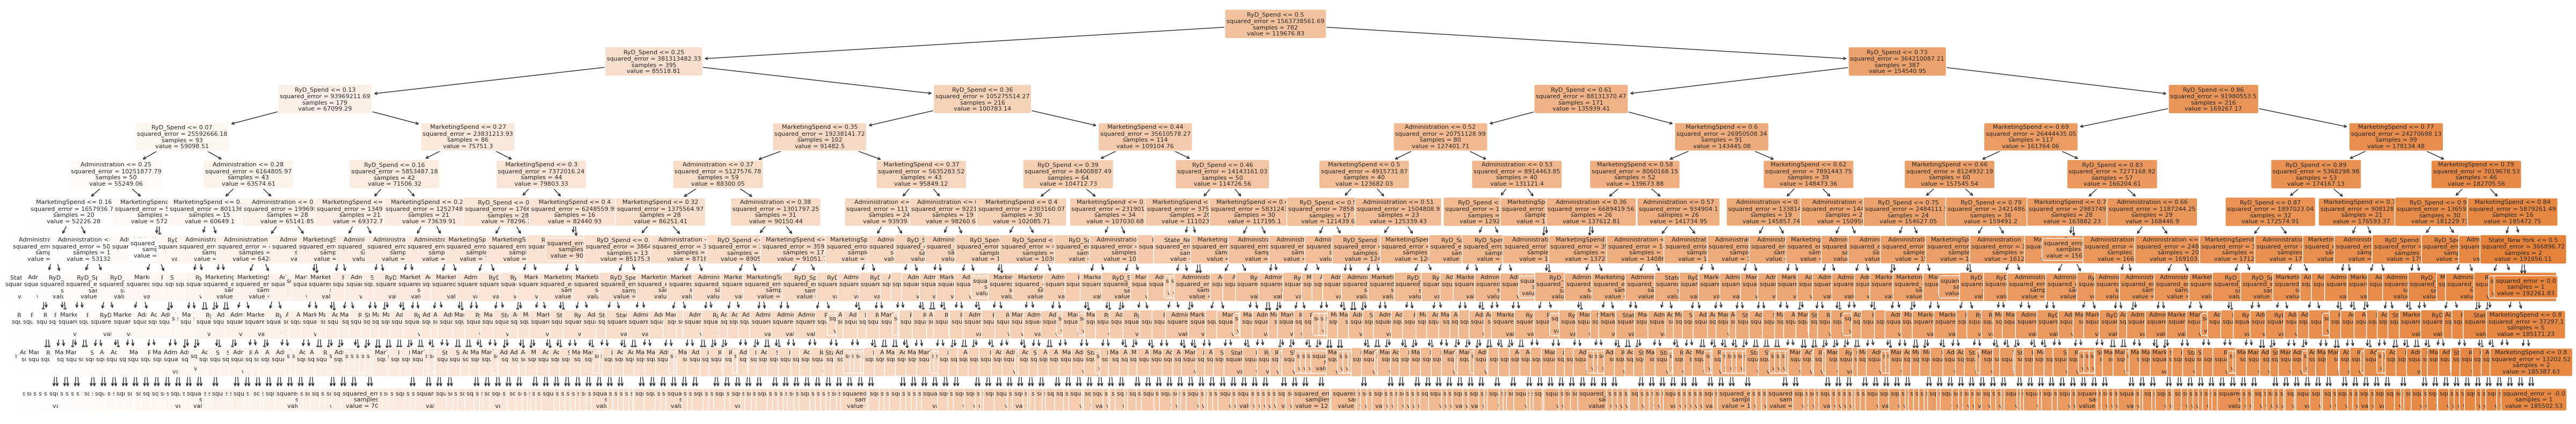

In [52]:
# Crear una lista de nombres de características utilizadas en el modelo
feature_list = list(X_train.columns)

# Crear una figura para la visualización del árbol
plt.figure(figsize=(60, 10))  # Ajusta el tamaño de la figura según tus preferencias

tree.plot_tree(
    best_model_rtree,
    feature_names=feature_list,
    fontsize=8,
    filled=True,
    rounded=True,
    precision=2    # Limitar la precisión de los valores mostrados en los nodos
)
# Guardar la visualización del árbol en un archivo PDF
plt.savefig("arbol_decision_regresion.pdf")

# Mostrar la visualización del árbol (puedes omitir esto si solo deseas guardar el archivo PDF)
plt.show()

> Dado a los mejores parámetros hallados con una única instancia por hoja y que la cantidad mínima de muestras para dividir un nodo sea 2, el árbol generado es enorme.

## 3 - Métricas

En esta sección se realiza el cálculo de diversas métricas para evaluar el rendimiento de un modelo de regresión con árboles de decisión.

In [50]:
# Obtener el mejor modelo con los hiperparámetros óptimos encontrados
best_model = grid_search.best_estimator_

# Realizar predicciones en el conjunto de prueba utilizando el mejor modelo
y_pred = best_model.predict(X_test)

# Asegurarse de que y_test y y_pred sean del tipo float
y_test = y_test.astype(float)

# Calcular las métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Calcular el error absoluto porcentual (APE) y luego el MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test) * 100)

# Calcular R-squared adjusted (R2 ajustado)
n = len(y_test)  # Número de observaciones
p = len(X_test.columns)  # Número de predictores (variables independientes)
r2_adjusted = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Imprimir las métricas redondeadas sin modificar los valores originales
print("Mean Absolute Percentage Error (MAPE):", round(mape, 2))
print("Mean Absolute Error (MAE):", round(mae, 2))
print("Mean Squared Error (MSE):", round(mse, 2))
print("Root Mean Squared Error (RMSE):", round(rmse, 2))
print("R-squared (R2):", round(r2, 2))
print("R-squared adjusted (R2 ajustado):", round(r2_adjusted, 2))

Mean Absolute Percentage Error (MAPE): 2.13
Mean Absolute Error (MAE): 490.33
Mean Squared Error (MSE): 15471843.0
Root Mean Squared Error (RMSE): 3933.43
R-squared (R2): 0.99
R-squared adjusted (R2 ajustado): 0.99


**Mean Absolute Percentage Error (MAPE)**

> MAPE mide el error porcentual promedio las predicciones. En este caso, un MAPE del 2.132% es muy bajo, lo que indica que las predicciones son muy precisas y se desvían en promedio solo en un 2.132% del valor real. Esto es una muy buena señal.

**Mean Absolute Error (MAE)**

> El MAE es la diferencia absoluta promedio entre las predicciones y los valores reales. Un MAE de 490.33 sugiere que, en promedio, las predicciones tienen una diferencia de aproximadamente 490.33 unidades en valor absoluto con respecto a los valores reales. Recordemos que la media de la variable respuesta 'Profit' es 119546.16, luego, el MAE representa un 0.41% de este valor

**Mean Squared Error (MSE)**

> El MSE es similar al MAE, pero castiga más fuertemente los errores grandes. Un MSE de 15,471,843.003 indica que los errores cuadrados y en promedio alcanzan este valor. Cuanto más bajo sea el MSE, mejor será el modelo. Esta métrica es buena durante el proceso de elegir características, umbrales o comparar modelos entre sí, pero no arroja muchos insights a la hora de evaluar un modelo particular.

**Root Mean Squared Error (RMSE)**

> El RMSE es la raíz cuadrada del MSE y proporciona una medida de error en la misma unidad que los datos originales. Un RMSE de 3,933.426 significa que, en promedio, tus predicciones se desvían en aproximadamente 3,933.43 unidades de los valores reales, es decir, un 3.3% de la media de la viable respuesta.

**R-squared (R2)**

> El coeficiente de determinación R2 es una medida de la bondad del ajuste del modelo. Un R2 de 0.99 es excelente y sugiere que el modelo explica el 99% de la variabilidad en los datos de "Profit". En otras palabras, el modelo se ajusta muy bien a los datos.

**R-squared adjusted (R2 ajustado)**

> El R2 ajustado es similar al R2, pero tiene en cuenta la complejidad del modelo al penalizar el uso excesivo de predictores. Un valor de 0.99 sugiere que el modelo es sólido y no está sobreajustando.

In [51]:
# Tabla de resultados
tableResult = pd.DataFrame({'Real':y_test, 'Predicho': y_pred})
tableResult

,Real,Predicho
199,54300.45973,54205.63339
543,97712.98433,97599.36358
174,76229.26494,76376.20305
928,161783.12860,161824.13460
66,140237.90020,140289.15770
...,...,...
361,51913.56964,51690.59960
883,121916.76750,122307.17860
525,77132.25091,77242.45450
971,165330.14630,165536.60010


## 4 - Conclusión

En este trabajo se buscó estimar las ganancias de startups utilizando un árbol de decisión de regresión. Los predictores incluyeron características clave como el gasto en investigación y desarrollo (R&D Spend), los gastos administrativos (Administration), y el gasto en actividades de marketing (Marketing Spend), así como el estado en el que opera cada startup.

El proceso de análisis comenzó con un análisis exploratorio y procesamiento de datos exhaustivo, que incluyó la identificación y eliminación de valores atípicos, la estandarización de datos y la codificación de variables categóricas. Esto garantizó la calidad de los datos y preparó el conjunto de datos para el modelado.

Se entrenó un modelo de regresión de árbol de decisión y se optimizaron los hiperparámetros utilizando grid search CV para obtener un rendimiento óptimo. Los resultados de evaluación del modelo revelaron un alto nivel de precisión, como lo demuestran las métricas obtenidas. El MAPE (Mean Absolute Percentage Error) del 2.13% indica que el modelo es altamente preciso en la estimación del profit de las startups. Además, el MAE (Mean Absolute Error) de 490.33 y el RMSE (Root Mean Squared Error) de 3933.43 sugieren que las predicciones del modelo están en línea con los valores reales, con un bajo nivel de error.

El R-cuadrado (R2) de 0.99, y el R-cuadrado ajustado (R2 ajustado) de 0.99 indican que el modelo es capaz de explicar casi la totalidad de la variabilidad en los datos de profit. Estos valores destacan la fuerte capacidad del modelo para capturar las relaciones entre las características predictoras y el profit de las startups.

En conclusión, este trabajo ha demostrado que el uso de un árbol de decisión de regresión junto con un análisis exhaustivo de datos y la optimización de hiperparámetros puede ser una estrategia efectiva para estimar el profit de startups basado en características clave al menos en lo que respecta a este conjunto de datos. Los resultados indican que el modelo es altamente preciso y puede ser una herramienta valiosa para la toma de decisiones empresariales al proporcionar estimaciones confiables del profit esperado en función de los gastos en investigación y desarrollo, gastos administrativos, gastos de marketing y la ubicación geográfica de la empresa.

# Parte II: Clasificación (Ítems de 3 a 6)

## 1 - Análisis exploratorio y procesamiento de los datos


In [12]:
# Importar el archivo CSV en un DataFrame de Pandas
pokemon_df= pd.read_csv("Datasets/PokemonDB.csv")

### 1.1 - Conocer el dataset

En esta sección conoceremos las columnas del dataset, sus nombres, cantidad, tipo, datos faltantes y medidas de localización y centralidad para las columnas numéricas.





In [6]:
# Usar el método .info() para obtener información sobre el DataFrame
print("Información del DataFrame:")
pokemon_df.info()

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Name     1190 non-null   object
 1   Type     1190 non-null   object
 2   HP       1190 non-null   int64 
 3   Attack   1190 non-null   int64 
 4   Defense  1190 non-null   int64 
 5   Sp. Atk  1190 non-null   int64 
 6   Sp. Def  1190 non-null   int64 
 7   Speed    1190 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 74.5+ KB


> Hay un total de 1190 filas en el DataFrame.

> El DataFrame tiene 8 columnas en total.

> Ninguna columna tiene datos faltantes.

> Las columnas "Name" y "Type" contienen valores de tipo object (texto).

> Las columnas "HP", "Attack", "Defense", "Sp. Atk", "Sp. Def" y "Speed" contienen valores de tipo int64 (enteros).

In [7]:
# Usar el método .describe() para obtener estadísticas descriptivas del DataFrame
print("\nEstadísticas descriptivas del DataFrame:")
print(pokemon_df.describe())


Estadísticas descriptivas del DataFrame:
                HP       Attack      Defense      Sp. Atk      Sp. Def  \
count  1190.000000  1190.000000  1190.000000  1190.000000  1190.000000   
mean     70.852941    80.957983    74.586555    72.756303    72.050420   
std      26.886443    32.119650    30.718212    32.658636    27.637522   
min       1.000000     5.000000     5.000000    10.000000    20.000000   
25%      51.250000    56.000000    51.000000    50.000000    50.000000   
50%      70.000000    80.000000    70.000000    65.000000    70.000000   
75%      85.000000   100.000000    90.000000    95.000000    90.000000   
max     255.000000   190.000000   250.000000   194.000000   250.000000   

             Speed  
count  1190.000000  
mean     69.695798  
std      30.204376  
min       5.000000  
25%      45.000000  
50%      67.000000  
75%      90.000000  
max     200.000000  


> Los valores de las columnas de enteros no se salen del rango (1, 255). Lo que tiene sentido porque las estadísticas base de los Pokémon están programadas para caber en 1 byte y ser más eficientes en almacenamiento, 1 byte = 8 bits -> (2^8 = 256) entonces los valores no pueden salir del rango (0, 255).
>
> También se observa que los valores correspondientes a la media y la mediana son muy similares en casi todas las columnas por los que las distribuciones son simétricas con una leve tendencia hacia los valores más pequeños.


### 1.2 - Distribuciones de los datos
En esta sección se utilizan raincloud plots para ilustrar la distribución de los datos.

Los raincloud plots, o gráficos de lluvia, combina una representación de la distribución de datos (la 'nube') con datos brutos dispersos (la 'lluvia') y se complementan aún más añadiendo boxplots.

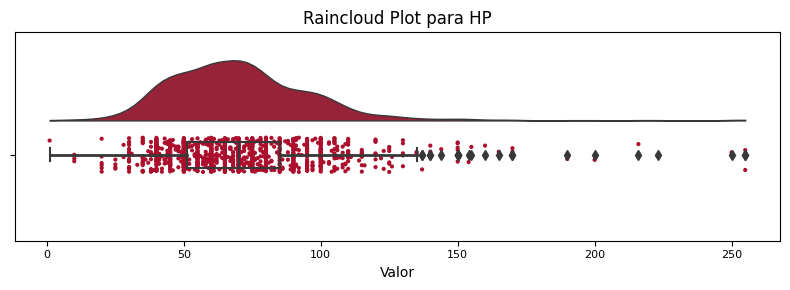

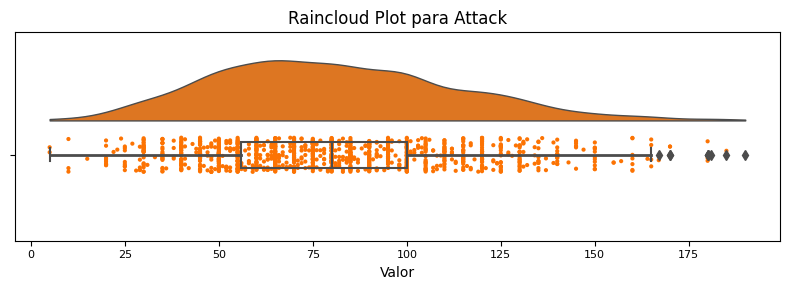

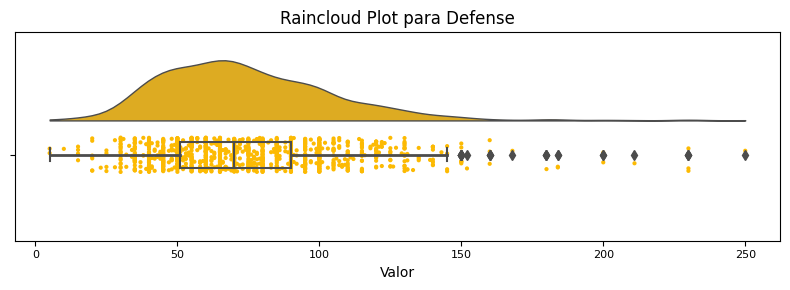

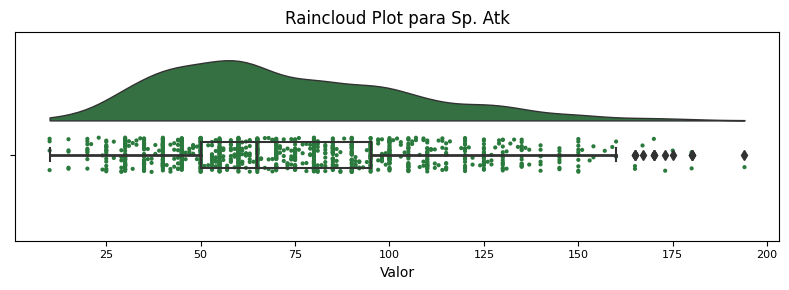

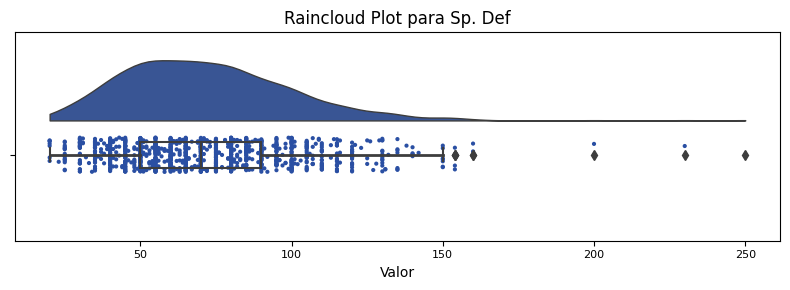

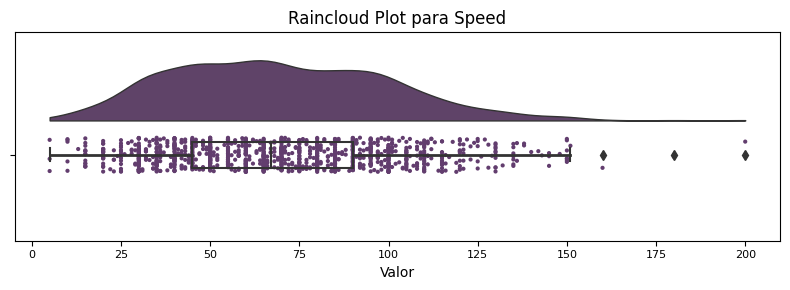

In [8]:
# Filtrar solo las columnas numéricas
numeric_columns = pokemon_df.select_dtypes(include='number')

# Paleta de colores
colors = ['#ab0f2c','#fc7303','#fcba03','#2b7a3d','#2a4fa3','#623d6e']

# Iterar a través de las columnas numéricas y crear un raincloud plot para cada una en su propia figura
for i, column_name in enumerate(numeric_columns.columns):

    # Configurar una nueva figura para cada columna
    plt.figure(figsize=(8, 3))

    # Crear el raincloud plot para la columna actual
    ax = pt.RainCloud(data=numeric_columns[column_name], orient='h', palette=[colors[i]])

    # Personalizar etiquetas de ejes y título para cada figura
    plt.xlabel('Valor', fontsize=10)
    plt.title(f'Raincloud Plot para {column_name}', fontsize=12)

    # Eliminar los números del eje y
    ax.set_yticklabels([])

    # Reducir el tamaño de los números en los ejes
    ax.tick_params(axis='both', labelsize=8)

    # Ajustar el espacio en blanco entre el eje x y el gráfico
    plt.tight_layout()

    # Mostrar la figura actual
    plt.show()

> Los gráficos muestran distribuciones asimétricas positivas, es decir los datos se concentran en los valores más bajos. Conociendo el dataset, estos valores anormalmente altos pueden ser legendarios o bien pokémon como Ninjask o Shuckle que tienen valores extremadamente altos de velocidad y defensas respectivamente, pero no son representativos del tipo Bicho (la clase objetivo). Por esto último serán eliminados para el entrenamiento de los modelos.

### 1.3 - Eliminación de outliers

En esta sección, se procede a la identificación y eliminación de valores atípicos, mediante la selección de un factor de rango intercuartílico apropiado. El objetivo es preservar la integridad del conjunto de datos al no eliminar más del 5% de los registros, una proporción ampliamente reconocida como estándar en la industria.

In [9]:
# Definir función de para eliminar outliers
def remove_outliers_iqr(df, column_name, iqr_factor=1.5):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_factor * IQR
    upper_bound = Q3 + iqr_factor * IQR
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

In [10]:
# Lista de columnas numéricas
numeric_columns = pokemon_df.select_dtypes(include='number')

# Crear copia del dataframe
filtered_df = pokemon_df.copy()

# Factor de multiplicación del rango intercuartil
iqr_factor = 1.6

# Iterar a través de las columnas numéricas y eliminar los outliers
for columna in numeric_columns:
    filtered_df = remove_outliers_iqr(filtered_df, columna, iqr_factor)

# Utilizar el método reset_index() para restablecer los índices
filtered_df = filtered_df.reset_index(drop=True)

In [11]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136 entries, 0 to 1135
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Name     1136 non-null   object
 1   Type     1136 non-null   object
 2   HP       1136 non-null   int64 
 3   Attack   1136 non-null   int64 
 4   Defense  1136 non-null   int64 
 5   Sp. Atk  1136 non-null   int64 
 6   Sp. Def  1136 non-null   int64 
 7   Speed    1136 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 71.1+ KB


In [12]:
print(f'Porcentaje de datos eliminados: {100*(1-len(filtered_df)/len(pokemon_df)):.1f}%')

Porcentaje de datos eliminados: 4.5%


Al eliminar los valores atípicos, se excluyó un 4.5% del conjunto de datos en su totalidad, lo cual se encuentra por debajo del umbral admisible universalmente del 5%.

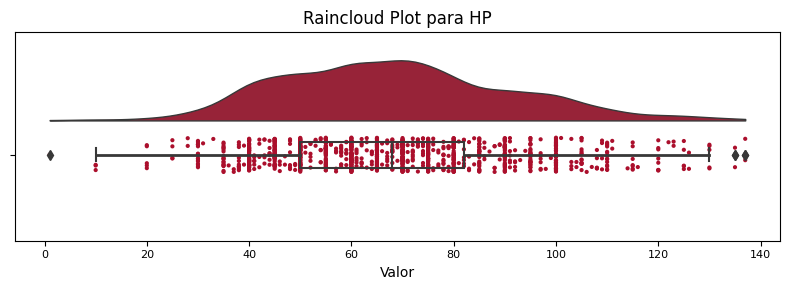

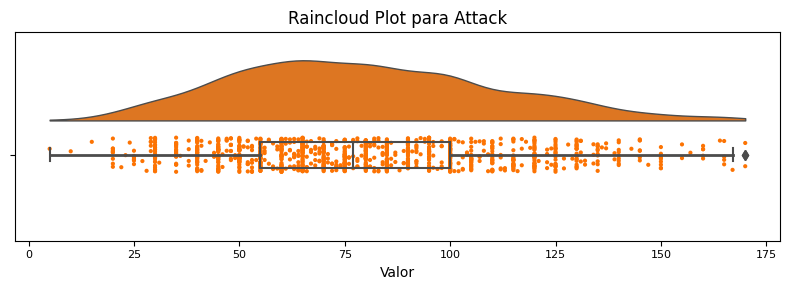

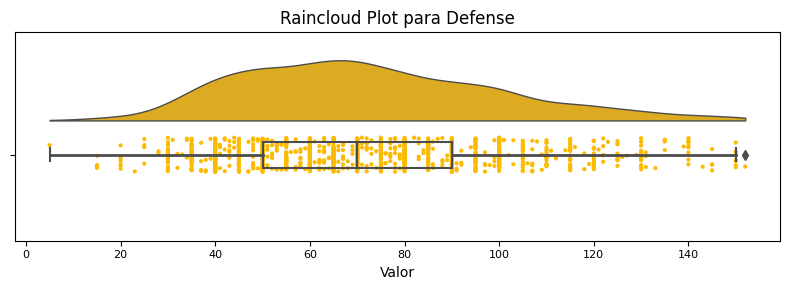

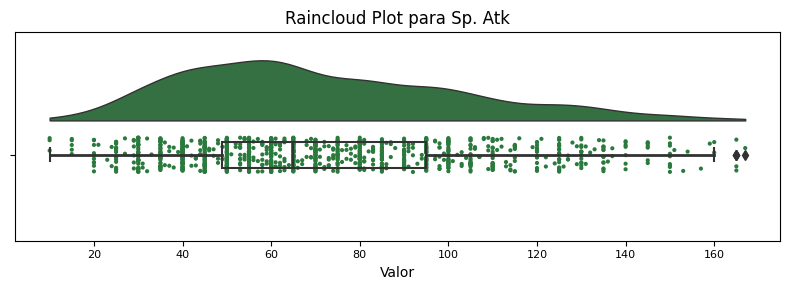

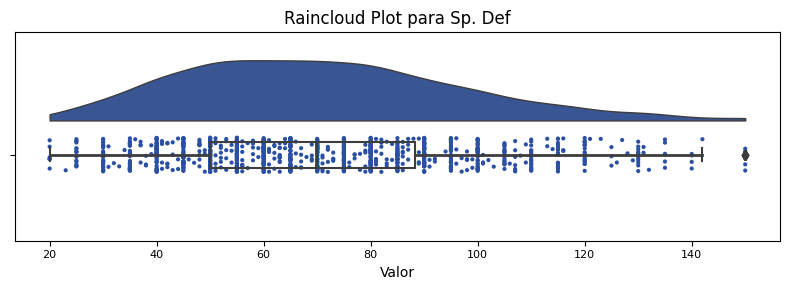

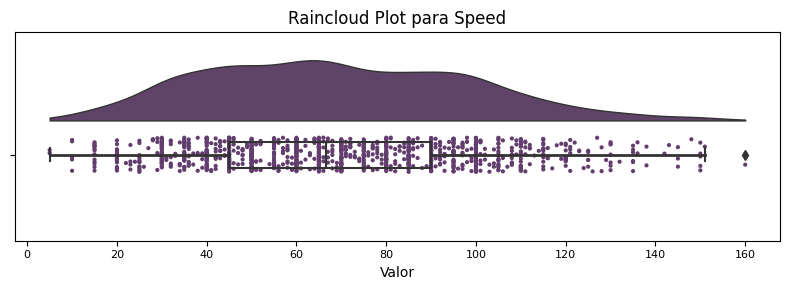

In [13]:
# Filtrar solo las columnas numéricas
numeric_columns = filtered_df.select_dtypes(include='number')

# Paleta de colores
colors = ['#ab0f2c','#fc7303','#fcba03','#2b7a3d','#2a4fa3','#623d6e']

# Iterar a través de las columnas numéricas y crear un raincloud plot para cada una en su propia figura
for i, column_name in enumerate(numeric_columns.columns):
    # Configurar una nueva figura para cada columna
    plt.figure(figsize=(8, 3))

    # Crear el raincloud plot para la columna actual
    ax = pt.RainCloud(data=numeric_columns[column_name], orient='h', palette=[colors[i]])

    # Personalizar etiquetas de ejes y título para cada figura
    plt.xlabel('Valor', fontsize=10)
    plt.title(f'Raincloud Plot para {column_name}', fontsize=12)

    # Eliminar los números del eje y
    ax.set_yticklabels([])

    # Reducir el tamaño de los números en los ejes
    ax.tick_params(axis='both', labelsize=8)

    # Ajustar el espacio en blanco entre el eje x y el gráfico
    plt.tight_layout()

    # Mostrar la figura actual
    plt.show()

Tras la eliminación de los valores atípicos y la representación gráfica de las distribuciones, se aprecia claramente cómo todas las columnas presentan ahora una distribución más simétrica.

### 1.4 - Correlación entre variables

En esta sección, se procede a la evaluación de las relaciones de correlación lineal entre las variables.

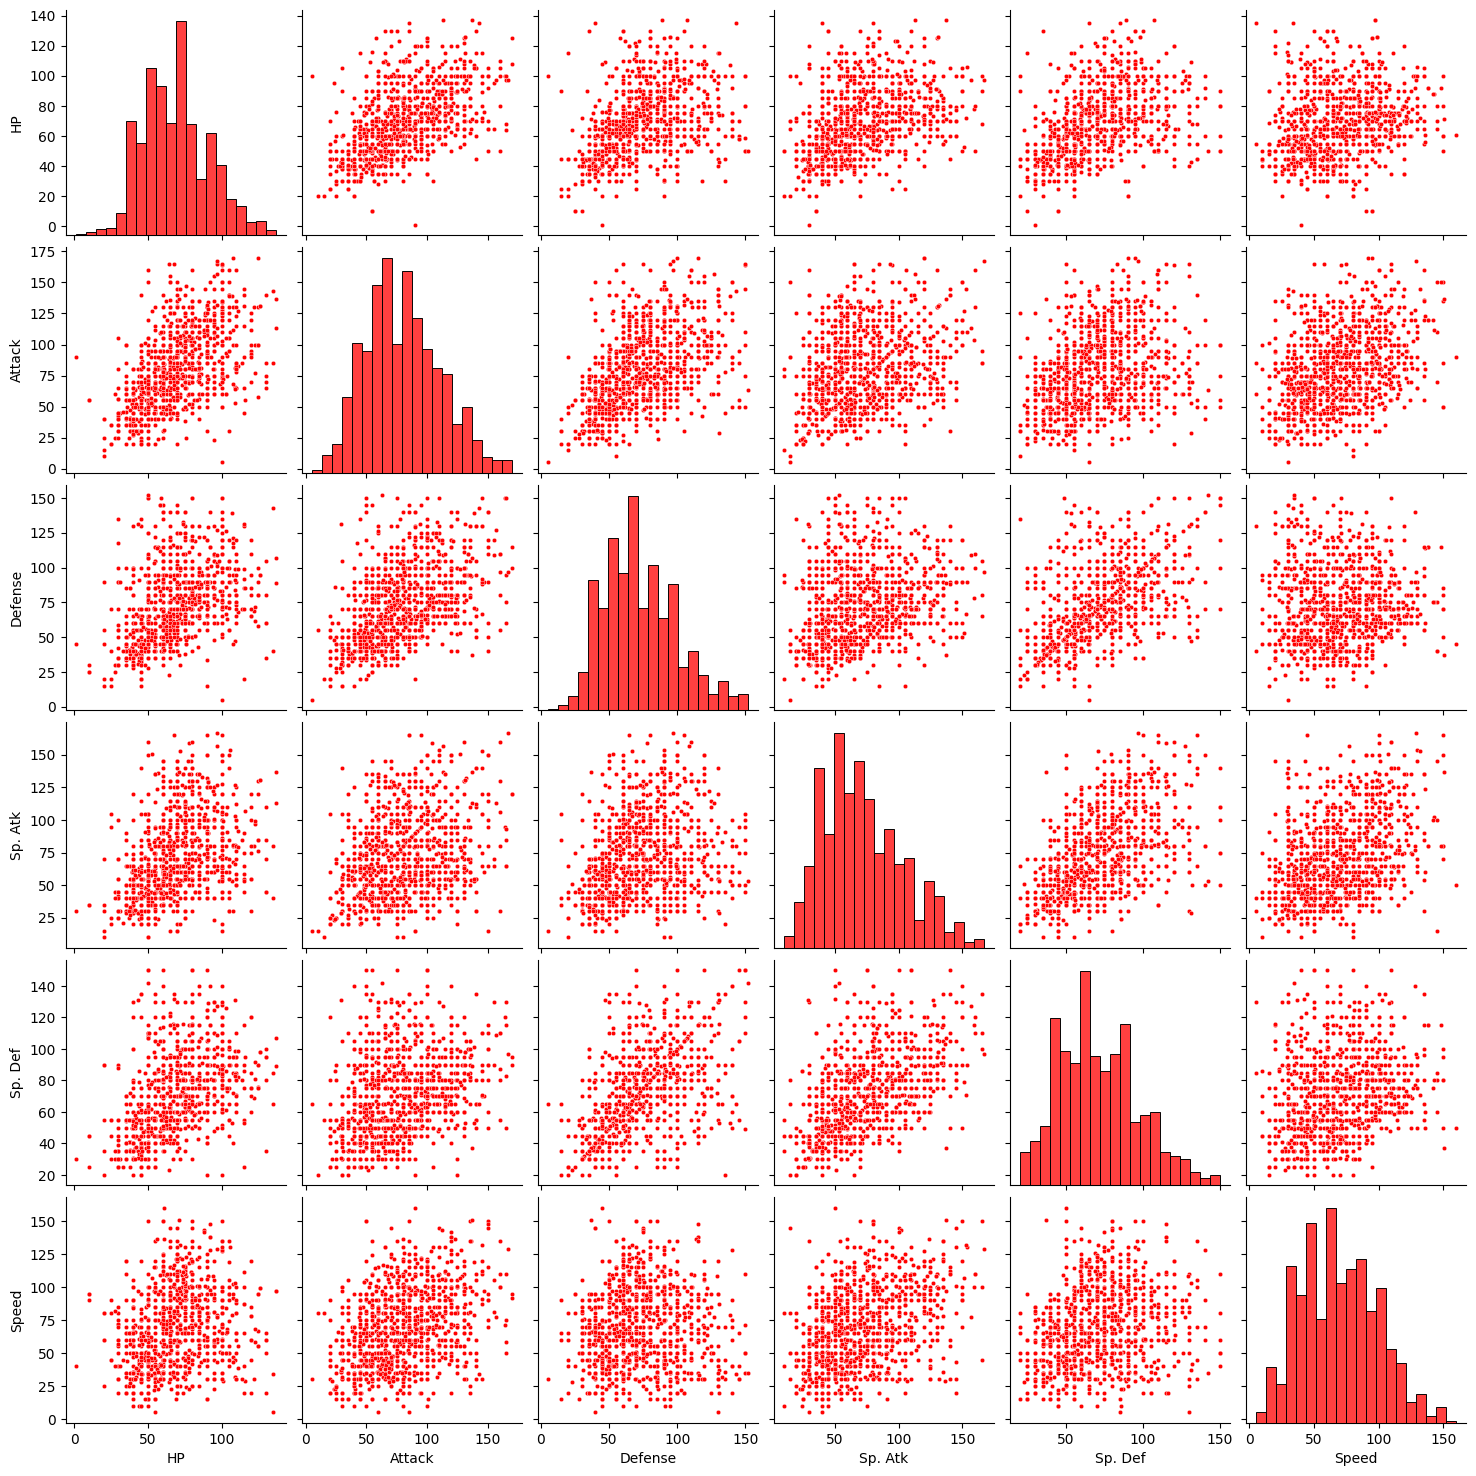

In [14]:
# Crear un pairplot
pairplot = sns.pairplot(filtered_df.select_dtypes(include=['number']), plot_kws={'color': 'red', 's': 10}, diag_kws={'color': 'red', 'bins': 20})
plt.show()

> En este gráfico puede observarse que algunos pares de características presentan una relación lineal muy pronunciada, pudiendo incluso verse líneas perfectas como en los pares "Defensa - Defensa Especial" y "Ataque - Ataque Especial".

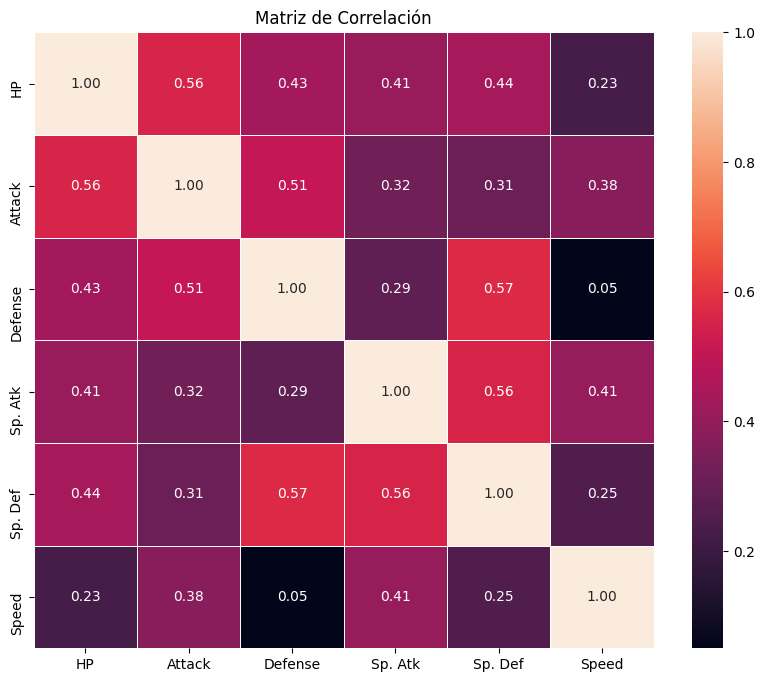

In [15]:
# Calcular la matriz de correlación
correlation_matrix = filtered_df.corr()

# Crear un mapa de calor de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap="rocket", annot=True, fmt=".2f", linewidths=.5)
plt.title("Matriz de Correlación")
plt.show()

> En los gráficos de dispersión y en la matriz de correlación, es evidente la presencia de correlaciones lineales significativas, como la correlación entre "Defensa" y "Defensa Especial" (0.57), así como entre "Ataque" y "Vida" (0.56), por mencionar algunas. Este hallazgo es de particular relevancia, ya que podría tener un impacto negativo en los modelos que se utilizarán, como el algoritmo Naive Bayes. Este último, se basa en la suposición de que los predictores son condicionalmente independientes, una suposición que en este caso parece no cumplirse.

## 2 - Clasificación con árbol de decisión
En esta parte se separan los conjuntos de entrenamiento y de prueba, se entrena un modelo de clasificación basado en árboles de decisión, se genera una representación en texto del árbol y luego visualiza el árbol de decisión.

### 2.1 - Separar en conjuntos de entrenamiento y de prueba

En esta sección se aborda la crucial tarea de dividir el conjunto de datos en dos subconjuntos: uno destinado al entrenamiento del modelo y otro para su evaluación. Este proceso asegura que el modelo sea probado con datos no vistos durante el entrenamiento, permitiendo una evaluación imparcial de su rendimiento y capacidad de generalización.


In [16]:
# Copiar el DataFrame "filtered_df" a "tree_classif_df" excluyendo la columna "Name"
tree_classif_df = filtered_df.drop(columns=["Name"]).copy()

# Crear un diccionario con las etiquetas
label_names = {i: label for i, label in enumerate(tree_classif_df['Type'].unique())}

# Definir las características (X) y las etiquetas (y).
X = tree_classif_df.drop(columns=["Type"])  # X contiene todas las columnas excepto "Type"
y = tree_classif_df["Type"]  # y contiene la columna "Type"

# Dividir el conjunto de datos en entrenamiento y prueba (por ejemplo, 80% entrenamiento, 20% prueba).
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X, y, test_size=0.2, random_state=42)

### 2.2 - Crear una instancia del clasificador

En esta sección, se crea una instancia del clasificador de árbol de decisión. Esta instancia se utiliza como base para construir un modelo de clasificación utilizando la técnica de árboles de decisión. El objeto representa el modelo de árbol de decisión antes de ajustar sus hiperparámetros o realizar cualquier entrenamiento con datos reales. Posteriormente, se pueden configurar los hiperparámetros y ajustar el modelo a un conjunto de datos específico para su posterior uso en la clasificación de observaciones.

In [17]:
# Crear un clasificador de árbol de decisión.
clf = DecisionTreeClassifier()

### 2.3 - Entrenar modelos y optimizar hiperparámetros

Esta sección se enfoca en la utilización de la biblioteca GridSearchCV con el propósito de identificar y ajustar de manera óptima los hiperparámetros de nuestro modelo, seleccionando las configuraciones más adecuadas a partir de un conjunto de opciones predefinidas.


In [18]:
# Definir los hiperparámetros que deseas optimizar y sus valores posibles.
param_grid_tree = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'criterion': ['gini', 'entropy']
}

# Crear un objeto GridSearchCV.
grid_search_tree = GridSearchCV(estimator=clf, param_grid=param_grid_tree, cv=5, scoring='accuracy', n_jobs=-1)

# Realizar la búsqueda en la cuadrícula en los datos de entrenamiento.
grid_search_tree.fit(X_train_tree, y_train_tree)

# Obtener el mejor modelo y sus hiperparámetros óptimos.
best_model_tree = grid_search_tree.best_estimator_
best_params_tree = grid_search_tree.best_params_

# Imprimir los hiperparámetros óptimos.
print("Hiperparámetros óptimos:", best_params_tree)

Hiperparámetros óptimos: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}


> El **criterio de separación** óptimo es 'entropy'. En los árboles de decisión, el criterio se utiliza para medir la calidad de la división de los nodos del árbol. 'Entropy' es una medida de la impureza de los nodos y se utiliza para maximizar la ganancia de información.

> La **profundidad máxima** del árbol de decisión es 5. Esto significa que el árbol se dividirá en un máximo de 5 niveles desde el nodo raíz hasta las hojas. Una profundidad máxima más pequeña puede dar como resultado un modelo más simple, mientras que una profundidad máxima mayor puede dar como resultado un modelo más complejo.

> El **número mínimo de observaciones requeridas en una hoja** es 2. Esto significa que una hoja del árbol solo se creará si contiene al menos 2 ejemplos. Este hiperparámetro ayuda a evitar que el árbol se ajuste demasiado a ruido en los datos.

> El **número mínimo de observaciones requeridas para dividir un nodo interno** es 6. Esto significa que un nodo se dividirá en dos si contiene al menos 6 ejemplos. Este hiperparámetro controla la división de nodos y puede ayudar a evitar divisiones poco significativas.

### 2.4 - Visualización del árbol

En esta sección se proporciona una representación gráfica y comprensible del modelo de árbol de decisión, mostrando las reglas y criterios utilizados para tomar decisiones. Esto facilita la interpretación y comprensión del funcionamiento del modelo en términos de decisiones basadas en características específicas.

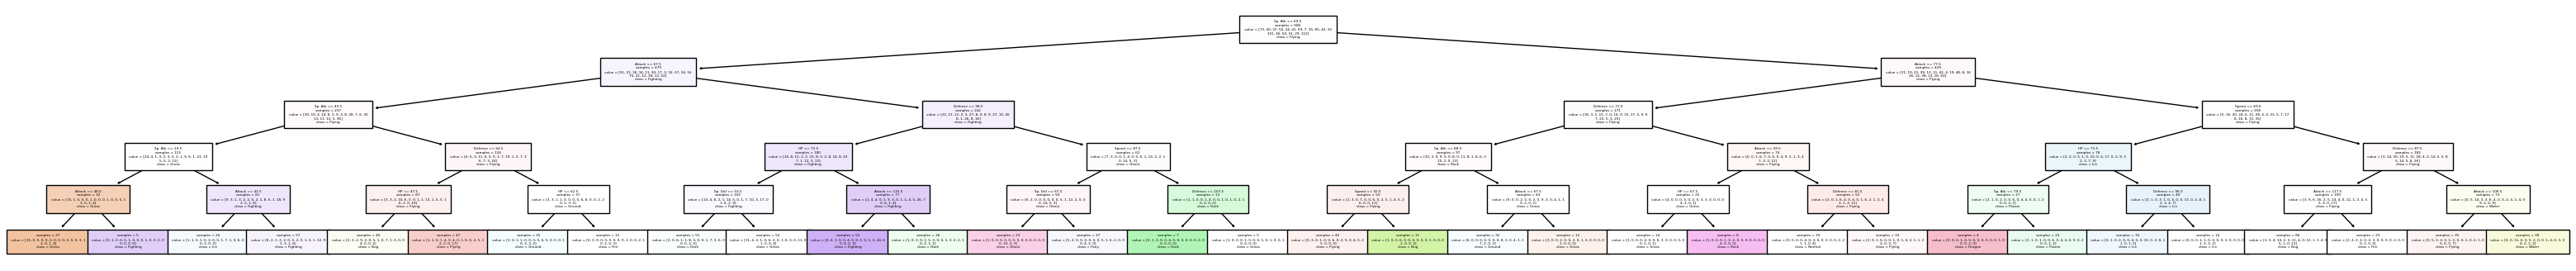

In [19]:
# Graficar el árbol de decisión y guardar la imagen en un archivo PDF.
plt.figure(figsize=(40, 4))
plot_tree(best_model_tree, filled=True, fontsize=3, feature_names=list(X.columns), impurity=False, class_names=list(y.unique()))
plt.savefig("arbol_decision_clasificacion.pdf")
plt.show()

### 2.5 - Matriz de confusión

La matriz de confusión permite examinar el rendimiento del modelo en términos de aciertos y errores en la clasificación de clases, lo que contribuye a una comprensión más profunda de su capacidad predictiva.

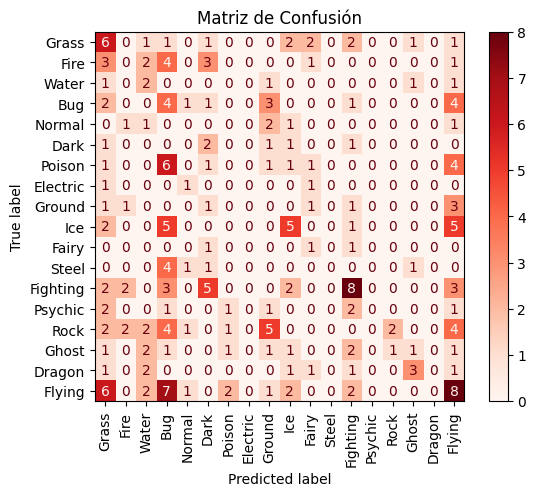

In [20]:
# Evaluar el modelo en el conjunto de prueba.
y_pred_tree = best_model_tree.predict(X_test_tree)

# Calcular la matriz de confusión
cm_tree = confusion_matrix(y_test_tree, y_pred_tree)

# Mostrar la matriz de confusión con etiquetas originales
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=label_names.values())
disp.plot(cmap='Reds', xticks_rotation='vertical')
plt.title("Matriz de Confusión")
plt.show()

**Verdaderos positivos (TP): Elementos en la diagonal principal**

> Estos valores representan la cantidad de instancias de cada clase que el modelo ha clasificado correctamente. Cuanto más altos sean estos valores en la diagonal principal, mejor será el rendimiento del modelo.
>
> En la matriz de confusión del árbol de decisión podemos ver una diagonal poco poblada, lo que indica un bajo rendimiento en general. En particular, se destaca una mayor tasa de aciertos en los tipos Planta, Hielo, Lucha y Volador.



**Falsos negativos (FN): Elementos en un fila no diagonales**

> Estos valores indican la cantidad de instancias de una clase específica que el modelo ha clasificado incorrectamente como otra clase. Un valor alto de FP puede sugerir que el modelo tiene dificultades para distinguir entre esas dos clases.
>
> Otra vez puede observarse un bajo rendimiento en este punto, por ejemplo, a pesar de haber acertado una gran cantidad de casos para el tipo Volador (8), también clasificó incorrectamente en otras clases a una gran cantidad de instancias (6+0+2+7+1+0+2+0+1+2+0+0+2+0+0+0+0 = 23).

**Falsos positivos (FP): Elementos en una columna no diagonales**

> Estos valores indican la cantidad de instancias que el modelo ha clasificado incorrectamente como de una clase pero en realidad resultan ser de otra. Un valor alto de FP señala que el modelo para identificar instancias de esa clase en particular.
>
> En este punto el modelo también tiene falencias ya que, utilizando el mismo ejemplo que antes, si bien el modelo clasificó correctamente 8 instancias de pokemon volador, también clasificó en esta clase una gran cantidad de instancias que en realidad, pertenecían a otra (1+1+1+4+1+0+4+0+3+5+0+0+3+1+4+1+1 = 30)



### 2.6 - Métricas del modelo

En esta sección, se calculan y muestran diversas métricas de evaluación del modelo de clasificación basado en un árbol de decisión. Las métricas calculadas son precisión, exactitud y exhaustividad.

In [21]:
# Calcular y mostrar las métricas de precisión, exactitud y recuperación
tree_accuracy = accuracy_score(y_test_tree, y_pred_tree)
tree_precision = precision_score(y_test_tree, y_pred_tree, average='weighted')
tree_recall = recall_score(y_test_tree, y_pred_tree, average='weighted')

print(f"Precisión: {tree_precision:.3f}")
print(f"Exhaustividad: {tree_recall:.3f}")
print(f"Exactitud: {tree_accuracy:.3f}")

Precisión: 0.198
Exhaustividad: 0.171
Exactitud: 0.171


**Precisión (Precision): 0.198**

> La precisión en un problema multiclase mide la proporción de predicciones correctas para una clase específica en relación con todas las predicciones realizadas para esa clase. En este caso, la precisión promedio para todas las clases es del 19.8%. Esto significa que, en promedio, solo el 19.8% de las predicciones para cada clase son correctas. Una precisión baja indica que el modelo tiende a hacer muchas predicciones incorrectas para las clases.

**Exhaustividad (Recall): 0.171**

> La exhaustividad (también conocida como recall) en un problema multiclase mide la proporción de ejemplos reales de una clase específica que se han predicho correctamente en relación con el total de ejemplos reales de esa clase. En este caso, la exhaustividad promedio para todas las clases es del 17.1%. Esto significa que, en promedio, solo el 17.1% de los ejemplos reales para cada clase se predicen correctamente. Una exhaustividad baja indica que el modelo tiende a perder muchos ejemplos positivos reales.

**Exactitud (Accuracy): 0.171**

> La exactitud en un problema multiclase mide la proporción de todas las predicciones correctas en relación con el total de predicciones realizadas. En este caso, la exactitud promedio para todas las clases es del 17.1%. Esto significa que, en promedio, solo el 17.1% de todas las predicciones son correctas. Una exactitud baja indica que el modelo no se desempeña bien en la clasificación de las clases.

## 3 - Clasificación con Bayes Ingenuo


### 3.1 - Separar los conjuntos de entrenamiento y prueba

In [22]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_mnb, X_test_mnb, y_train_mnb, y_test_mnb = train_test_split(X, y, test_size=0.2, random_state=42)

### 3.2 - Inicializar y entrenar del modelo de Naïve Bayes Multinomial
Este clasificador fue escogido por ser el mejor cuando los datos toman valores enteros no negativos.

In [23]:
# Crear y entrenar el modelo MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_mnb, y_train_mnb)

# Realizar predicciones en el conjunto de prueba
y_pred_mnb = mnb.predict(X_test_mnb)

### 3.3 - Matriz de cofusión

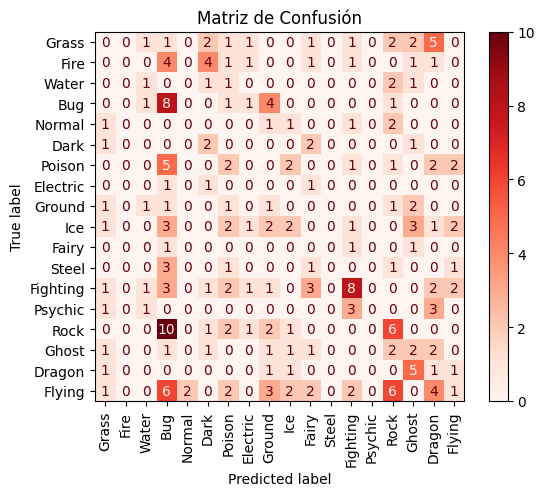

In [24]:
# Calcular la matriz de confusión
cm_mnb = confusion_matrix(y_test_mnb, y_pred_mnb)

# Mostrar la matriz de confusión con etiquetas originales
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mnb, display_labels=label_names.values())
disp.plot(cmap='Reds', xticks_rotation='vertical')
plt.title("Matriz de Confusión")

plt.show()

En la matriz de confusión multiclase, es evidente que una fracción minoritaria de los datos se sitúa en la diagonal de la matriz, la cual representa predicciones acertadas. Esto sugiere un desempeño subóptimo en la evaluación. No obstante, para obtener una comprensión más precisa y detallada de su rendimiento, se llevará a cabo el cálculo de métricas específicas en la siguiente sección.

### 3.4 - Métricas de Multinomial Naive Bayes

In [25]:
# Calcular y mostrar las métricas de precisión, exactitud y exhaustividad
mnb_accuracy = accuracy_score(y_test_mnb, y_pred_mnb)
mnb_precision = precision_score(y_test_mnb, y_pred_mnb, average='weighted')
mnb_recall = recall_score(y_test_mnb, y_pred_mnb, average='weighted')

print(f'Precision: {mnb_precision:.3f}')
print(f'Accuracy: {mnb_accuracy:.3f}')
print(f'Recall: {mnb_recall:.3f}')

Precision: 0.141
Accuracy: 0.149
Recall: 0.149


**Precision (Precisión)**

> El valor de precisión es 0.141, lo que significa que solo alrededor del 14.1% de las predicciones positivas realizadas por el modelo fueron correctas. En otras palabras, el modelo tiene una alta tasa de falsos positivos.

**Accuracy (Exactitud)**

> La exactitud es de 0.149, lo que indica que el modelo acierta aproximadamente el 14.9% de las predicciones en general. Sin embargo, una exactitud baja podría deberse a un desequilibrio en las clases objetivo o a un rendimiento deficiente del modelo.

**Recall (Exhaustividad)**

> El valor de recall es 0.149, lo que significa que solo se capturan aproximadamente el 14.9% de todos los casos verdaderos positivos. El recall es bajo, lo que indica que el modelo no es efectivo en la identificación de casos positivos.

## 4 - Clasificación con K-NN (k-Nearest Neighbors)

### 4.1 - Estandarización
En esta sección, se procederá a la estandarización de los datos en preparación para la aplicación del algoritmo K-NN. La estandarización es un paso esencial para asegurar que todas las características tengan un rango y escala comparables, lo que facilita el cálculo de las distancias entre puntos, un aspecto crítico en el funcionamiento efectivo del algoritmo K-NN.

Se ha elegido la técnica de escalamiento Min-Max. Esta elección se basa en varios factores clave que incluyen la falta de una distribución normal en los datos, lo cual descarta la aplicación de la transformación Z-Score. Además, la eliminación de valores atípicos previamente realizada descarta el uso de un enfoque robusto, y la inexistencia de una relación logarítmica en los datos hace inapropiado el empleo de la técnica homónima.

In [26]:
# Hacer una copia del DataFrame original
standardized_df = filtered_df.copy()

# Seleccionar las columnas numéricas para estandarizar
numeric_columns = [col for col in filtered_df.select_dtypes(include='number')]

# Crear un MinMaxScaler
scaler = MinMaxScaler()

# Estandarizar las columnas numéricas seleccionadas
standardized_df[numeric_columns] = scaler.fit_transform(filtered_df[numeric_columns])

# Mostrar el DataFrame estandarizado
standardized_df

,Name,Type,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,Bulbasaur,Grass,0.323529,0.266667,0.299320,0.350318,0.346154,0.258065
1,Ivysaur,Grass,0.433824,0.345455,0.394558,0.445860,0.461538,0.354839
2,Venusaur,Grass,0.580882,0.466667,0.530612,0.573248,0.615385,0.483871
3,Venusaur,Grass,0.580882,0.575758,0.802721,0.713376,0.769231,0.483871
4,Charmander,Fire,0.279412,0.284848,0.258503,0.318471,0.230769,0.387097
...,...,...,...,...,...,...,...,...
1131,Chi-Yu,Dark,0.397059,0.454545,0.510204,0.796178,0.769231,0.612903
1132,Roaring Moon,Dragon,0.764706,0.812121,0.448980,0.286624,0.623077,0.735484
1133,Iron Valiant,Fairy,0.536765,0.757576,0.578231,0.700637,0.307692,0.716129
1134,Koraidon,Fighting,0.727941,0.787879,0.748299,0.477707,0.615385,0.838710


### 4.2 - Separar en conjuntos de entrenamiento y prueba

In [27]:
# Copiar el DataFrame "standardized_df" a "knn_classif_df" excluyendo la columna "Name".
knn_classif_df = standardized_df.drop(columns=['Name']).copy()

# Definir las características (X) y las etiquetas (y).
X = knn_classif_df.drop(columns=["Type"])  # X contiene todas las columnas excepto "Type".
y = knn_classif_df["Type"]  # y contiene la columna "Type".

# Dividir el conjunto de datos en entrenamiento y prueba (por ejemplo, 80% entrenamiento, 20% prueba).
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X, y, test_size=0.2, random_state=42)

### 4.3 - Inicializar el clasificador y el optimizador de hiperparámetros

In [28]:
# Inicializar el clasificador KNN
knn_model_GSCV = KNeighborsClassifier()

# Definir los parámetros a ajustar
parametros_grid_knn = {'n_neighbors':  range(1, 15, 2),
                       'p':[1,2],
                       'weights': ['uniform', 'distance'] }

# Inicializar el objeto GridSearchCV
grid_search_knn = GridSearchCV(estimator = knn_model_GSCV,
                           param_grid = parametros_grid_knn,
                           cv=5,
                           scoring='accuracy')

### 4.4 - Optimización de hiperparámetros

In [29]:
# Realizar la búsqueda de hiperparámetros en el conjunto de entrenamiento
grid_search_knn.fit(X_train_knn, y_train_knn)

# Obtener el mejor modelo entrenado
mejor_modelo_knn = grid_search_knn.best_estimator_

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search_knn.best_params_)

Mejores hiperparámetros: {'n_neighbors': 13, 'p': 1, 'weights': 'distance'}


**n_neighbors: 13**

> Este hiperparámetro representa el número de vecinos más cercanos que se tomarán en cuenta al realizar una predicción para una nueva instancia. En este caso, el valor óptimo es 13, lo que significa que se considerarán los 13 vecinos más cercanos para tomar decisiones de clasificación.

**p: 1**

> Este hiperparámetro corresponde a la métrica de distancia utilizada en el algoritmo KNN. Cuando p es igual a 1 (como en este caso), se está utilizando la distancia de Manhattan (también conocida como L1 norm), que mide la distancia como la suma de las diferencias absolutas de las coordenadas.

**weights: 'distance'**

> Este hiperparámetro determina cómo se ponderan los vecinos al realizar una predicción. En este caso, se ha elegido 'distance', lo que significa que los vecinos más cercanos tienen un peso más alto en la predicción en función de la inversa de su distancia. Esto da más importancia a los vecinos más cercanos y puede mejorar la precisión del modelo.

### 4.5 - Matriz de confusión

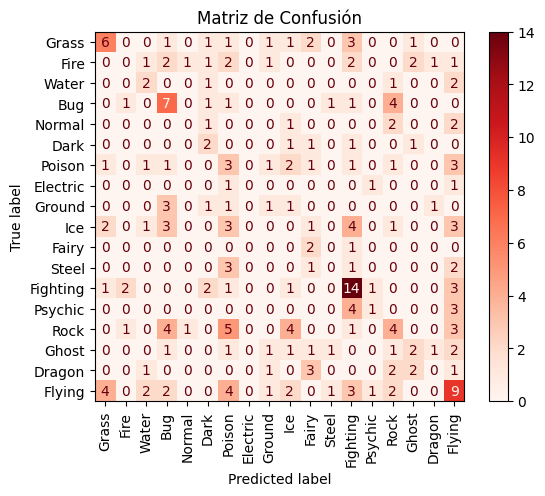

In [30]:
# Realizar predicciones en el conjunto de prueba
y_pred_knn = mejor_modelo_knn.predict(X_test_knn)

# Calcular la matriz de confusión
cm_knn = confusion_matrix(y_test_knn, y_pred_knn)

# Mostrar la matriz de confusión con etiquetas originales
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=label_names.values())
disp.plot(cmap='Reds', xticks_rotation='vertical')
plt.title("Matriz de Confusión")
plt.show()

> En el modelo K-Nearest Neighbors (KNN), se destaca una mayor concentración de instancias en la diagonal principal de la matriz de confusión, con una particular prominencia en el tipo "Lucha". No obstante, se observa que persiste un número significativo de instancias mal clasificadas en otras categorías.

### 4.6 - Métricas de K-NN


In [31]:
# Calcular y mostrar las métricas de precisión, exactitud y recuperación
knn_precision = precision_score(y_test_knn, y_pred_knn, average='weighted')
knn_accuracy = accuracy_score(y_test_knn, y_pred_knn)
knn_recall = recall_score(y_test_knn, y_pred_knn, average='weighted')

print(f'Precision: {knn_precision:.3f}')
print(f'Accuracy: {knn_accuracy:.3f}')
print(f'Recall: {knn_recall:.3f}')

Precision: 0.201
Accuracy: 0.232
Recall: 0.232


**Precision (Precisión)**

> En este caso, la precisión es 0.201. Esto significa que de todas las predicciones que el modelo hizo para una clase específica, el 20.1% de esas predicciones fueron correctas. En otras palabras, el modelo tiene una tasa de falsos positivos relativamente alta.

**Accuracy (Exactitud)**

> La exactitud es 0.232, lo que indica que el modelo clasifica correctamente el 23.2% de las muestras en el conjunto de prueba. Esto es bastante bajo y sugiere que el modelo no es muy preciso en general.

**Recall (Ehaustividad)**

> La exhaustivdad es 0.232, lo que significa que el modelo identifica correctamente el 23.2% de todas las muestras de una clase específica en el conjunto de prueba. En otras palabras, el modelo no es muy bueno para identificar positivos verdaderos.

## 5 - Resultados

### 5.1 - Metrícas de los modelos

In [32]:
# Definir los valores
modelos = ["Decision Tree", "MN Bayes", "K-NN"]
precision = [tree_precision, mnb_precision, knn_precision]
accuracy = [tree_accuracy, mnb_accuracy, knn_accuracy]
recall = [tree_recall, mnb_recall, knn_recall]

# Crear el DataFrame
data = {
    "Modelo": modelos,
    "Precision": precision,
    "Accuracy": accuracy,
    "Recall": recall
}

results_df = pd.DataFrame(data)

# Mostrar el DataFrame
results_df

,Modelo,Precision,Accuracy,Recall
0,Decision Tree,0.197629,0.171053,0.171053
1,MN Bayes,0.141017,0.149123,0.149123
2,K-NN,0.201012,0.232456,0.232456


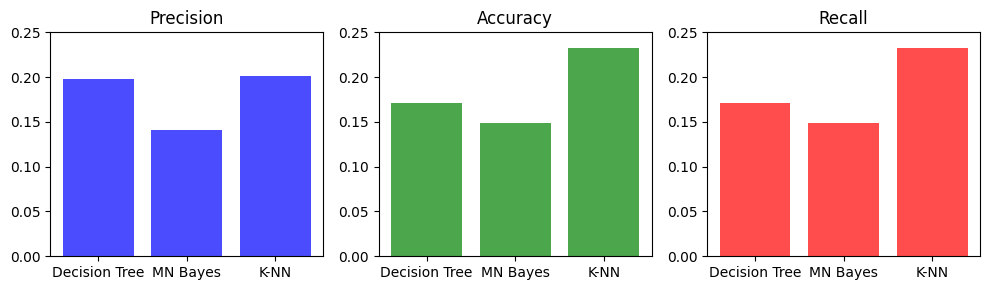

In [33]:
# Definir los nombres de los modelos y las métricas
modelos = results_df["Modelo"]
precision = results_df["Precision"]
accuracy = results_df["Accuracy"]
recall = results_df["Recall"]

# Crear un gráfico de barras para cada métrica
plt.figure(figsize=(10, 3))

# Gráfico de barras para Precision
plt.subplot(131)
plt.bar(modelos, precision, color='b', alpha=0.7)
plt.title('Precision')
plt.ylim(0, 0.25)

# Gráfico de barras para Accuracy
plt.subplot(132)
plt.bar(modelos, accuracy, color='g', alpha=0.7)
plt.title('Accuracy')
plt.ylim(0, 0.25)

# Gráfico de barras para Recall
plt.subplot(133)
plt.bar(modelos, recall, color='r', alpha=0.7)
plt.title('Recall')
plt.ylim(0, 0.25)

plt.tight_layout()
plt.show()


> Puede verse como la clasificación por K-NN da un mejor resultado para la clasificación en todas las métricas seguido por el árbol de decisión y en último lugar el Multinomial Naive Bayes.

### 5.2 - Conclusión

En el transcurso de este trabajo, se llevaron a cabo implementaciones y comparaciones de tres modelos de clasificación: Árboles de Decisión, Naive Bayes y K-Vecinos Más Cercanos (K-NN), con el propósito de predecir el tipo de un Pokémon en función de sus estadísticas base. El enfoque metodológico abarcó una exhaustiva exploración de los datos, incluyendo una descripción detallada de las columnas, el análisis de medidas de localización y centralidad de los valores, la evaluación de la distribución de los valores de las columnas y el examen de la correlación entre pares de variables.

A continuación, se procedió con la implementación de los modelos mencionados, dividiendo los datos en conjuntos de entrenamiento y prueba. Para mejorar su desempeño, se optimizaron los hiperparámetros de los modelos Árbol de Decisión y K-NN. Posteriormente, se llevaron a cabo análisis de las matrices de confusión de los mejores modelos y se obtuvieron métricas fundamentales, incluyendo Precision (Precisión), Accuracy (Exactitud) y Recall (Exhaustividad).

Los resultados obtenidos revelaron un desempeño generalmente insatisfactorio en lo que respecta a la capacidad de determinar el tipo de Pokémon. El modelo de K-Vecinos Más Cercanos (K-NN) se posicionó como el mejor intérprete de los datos, seguido por el Árbol de Decisión, y en última instancia, el modelo Naive Bayes.

Se optó por implementar el clasificador Naive Bayes en su variante Multinomial, diseñada para manejar datos enteros no negativos, una característica acorde con la naturaleza de nuestro conjunto de datos. A pesar de esta elección, se exploró también la opción del modelo Gaussiano, cuyo rendimiento resultó incluso menos satisfactorio. Es relevante destacar que se intentó optimizar el hiperparámetro del suavizado Laplaciano (alfa) en el modelo Multinomial Naive Bayes con el propósito de evitar la probabilidad condicional igual a cero. Sin embargo, este esfuerzo resultó infructuoso, ya que el valor óptimo para alfa se mantuvo en 0 de manera consistente.

Un aspecto adicional que podría explicar el bajo rendimiento del modelo Naive Bayes Multinomial radica en la suposición de independencia condicional entre predictores, una característica fundamental del modelo Bayesiano Ingenuo. En este contexto, el análisis exploratorio de datos evidenció la existencia de correlación significativa entre algunos pares de características, lo cual podría haber incidido en el rendimiento del modelo.

Finalmente, se concluye que las estadísticas base de los Pokémon podrían no ser un indicador idóneo de su tipo. A pesar de esto, entre los modelos evaluados, K-Vecinos Más Cercanos (K-NN) destaca como la elección preferente para abordar esta tarea, aunque se reconoce que aún existen desafíos en la mejora del rendimiento, los cuales pueden requerir un enfoque más sofisticado o la consideración de otras fuentes de información en investigaciones futuras.
